In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib import collections as mc
import networkx as nx
# import nxpd as nxpd  # pip install nxpd if you haven't
import nxpd
import community as comm
import GraphTools as gt
from collections import deque
from itertools import product

In [1]:
# get Korean language to show on matplotlib
import matplotlib
import matplotlib.font_manager as fm
font_location = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc("font",family=font_name)

In [2]:
df = pd.read_csv("../data/p_store_ordersub2019.csv")

In [3]:
df.head()

,orderno,seq,branch,saledate,saletime,gcode,mcode,mname,qty,unitprice,amount,dcamount
0,201903140001,1,BK0008,20190314,1411,1100.0,1108,봉주르크로아상,1,1300.0,1300.0,0.0
1,201903140001,2,BK0008,20190314,1411,1100.0,394,수제쿠키,1,1000.0,1000.0,0.0
2,201904160001,1,BK0008,20190416,1224,1400.0,980,자몽에이드,1,3000.0,3000.0,0.0
3,201906110001,1,BK0008,20190611,1756,1100.0,385,단팥빵,1,1200.0,1200.0,0.0
4,201906110001,2,BK0008,20190611,1756,1100.0,392,소보로빵,1,1200.0,1200.0,0.0


In [383]:
def prep_df(df):
    # drop stores with different menus
    df = df[(df["branch"] != "bk0026") 
         & (df["branch"] != "BK0021")].copy()
    
    # convert date and time to datetime object
    df["sale_datetime"] = df["saledate"].astype("str") + df["saletime"].astype("str").str.zfill(4)
    df["sale_datetime"] = pd.to_datetime(df["sale_datetime"], format='%Y%m%d%H%M')
    
    # clean up discount names
    cleanup_names = {
    "mnames": {"ice- 아메리카노": "아이스아메리카노",
               "ice-아메리카노(할인)": "(500원할인)아이스아메리카노",
               "(할인)ice-아메리카노": "(500원할인)아이스아메리카노",
               "(~10/15할인)ice-아메리카노":"(500원할인)아이스아메리카노",
               "(할인)아이스아메리카노": "(500원할인)아이스아메리카노",
               "(할인)아메리카노":"(500원할인)아메리카노",
               "아메리카노(할인)":"(500원할인)아메리카노",
               "(~10/15할인)아메리카노":"(500원할인)아메리카노"}}
    
    # clean up "ice-" menu names
    df["mname"].replace(regex={r"ice(-)?(\s)?":'아이스'}, inplace=True)
    
    # drop two values with na
    df.dropna(inplace=True)

    return df

In [384]:
menu_df = prep_df(df)

Text(0, 0.5, 'Count')

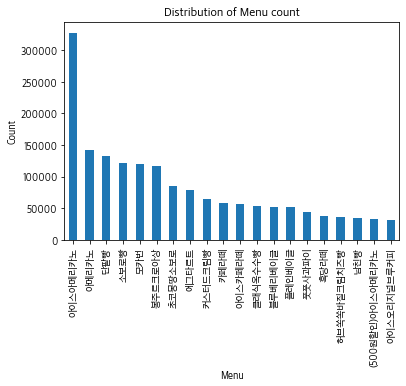

In [319]:
fig, ax = plt.subplots()
menu_df["mname"].value_counts()[:20].plot(kind="bar", ax=ax)
ax.set_title("Distribution of Menu count")
ax.set_xlabel("Menu")
ax.set_ylabel("Count")

In [320]:
for name, value in zip(menu_df["mname"].value_counts().index, menu_df["mname"].value_counts()):
    print(f"{name}: {value}")

아이스아메리카노: 327594
아메리카노: 141953
단팥빵: 131954
소보로빵: 121129
모카번: 119826
봉주르크로아상: 117365
초코몽땅소보로: 85508
에그타르트: 79165
커스터드크림빵: 64623
카페라떼: 57996
아이스카페라떼: 55867
클래식옥수수빵: 54204
블루베리베이글: 52186
플레인베이글: 51702
풋풋사과파이: 43763
흑당라떼: 38073
허브쏙쏙바질크림치즈빵: 35909
남친빵: 35062
(500원할인)아이스아메리카노: 32724
아이스오리지널브루커피: 31665
버터크림빵: 31194
블루베리스콘: 30524
매콤부추고로케: 28912
(500원할인)아메리카노: 28211
촉촉한치즈타르트: 26777
SizeUP: 24400
호두타르트: 23036
NEW텔라번: 21585
아이스바닐라라떼: 21157
크랜베리베이글: 21031
부드러운피자번: 19440
묶음빵: 19344
미니잡곡호두식빵: 18716
크림치즈모카번: 18572
미니쌀우유식빵: 18418
샷하나: 17730
복숭아아이스티: 16983
미니먹물치즈식빵: 16575
캐리어: 15568
아이스달콤라떼: 15521
못난이치즈감자빵: 13422
왕꽈배기: 13305
네입에피자: 13143
모카봉주르크로와상: 13059
보스턴핫도그: 11393
브라우니타르트: 11290
단팥찹쌀도넛: 11270
바닐라라떼: 10983
비닐봉투: 10144
스위트콘브레드: 9833
크랜베리스콘: 9811
메이플파이: 9647
초코청크머핀: 8920
샷 추가: 8700
씨앗쿠키: 8625
달콤라떼: 8276
초코달팽이: 7984
초콜릿커스타드크림빵: 7980
바질쏙쏙갈릭바게트: 7849
초코찐득브라우니: 7674
(할인)아메리카노: 7657
치즈베이글: 7566
먹물치즈콕콕브레드: 7440
오리지널브루커피: 7141
바싹치즈볼: 6680
치즈콕콕브레드: 6625
Size Up: 6620
(S)아메리카노: 6419
연하게: 6393
얼음추가: 6178
얼룩초코크로

In [331]:
menu_df["mname"].nunique()

398

In [322]:
menu_df.head()

,orderno,seq,branch,saledate,gcode,mcode,mname,qty,unitprice,amount,dcamount,sale_datetime
0,201903140001,1,BK0008,20190314,1100.0,1108,봉주르크로아상,1,1300.0,1300.0,0.0,2019-03-14 14:11:00
1,201903140001,2,BK0008,20190314,1100.0,394,수제쿠키,1,1000.0,1000.0,0.0,2019-03-14 14:11:00
2,201904160001,1,BK0008,20190416,1400.0,980,자몽에이드,1,3000.0,3000.0,0.0,2019-04-16 12:24:00
3,201906110001,1,BK0008,20190611,1100.0,385,단팥빵,1,1200.0,1200.0,0.0,2019-06-11 17:56:00
4,201906110001,2,BK0008,20190611,1100.0,392,소보로빵,1,1200.0,1200.0,0.0,2019-06-11 17:56:00


In [447]:
def get_agg(df):
    agg_df = df.groupby(["orderno","branch"])["mname"].apply(lambda x: x.tolist()).reset_index()
    return agg_df
agg_df = get_agg(menu_df)

Text(0, 0.5, 'Counts')

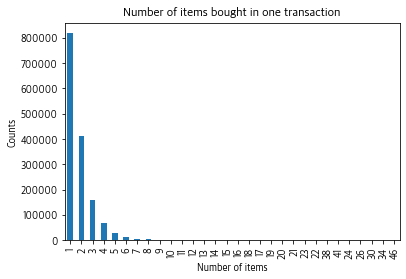

In [324]:
fig, ax = plt.subplots()
agg_df["mname"].apply(len).value_counts().plot(kind="bar", ax=ax)
ax.set_title("Number of items bought in one transaction")
ax.set_xlabel("Number of items")
ax.set_ylabel("Counts")

In [404]:
menu_list = np.array(menu_df["mname"].value_counts().index)
menu_list

array(['아이스아메리카노', '아메리카노', '단팥빵', '소보로빵', '모카번', '봉주르크로아상', '초코몽땅소보로',
       '에그타르트', '커스터드크림빵', '카페라떼', '아이스카페라떼', '클래식옥수수빵', '블루베리베이글',
       '플레인베이글', '풋풋사과파이', '흑당라떼', '허브쏙쏙바질크림치즈빵', '남친빵',
       '(500원할인)아이스아메리카노', '아이스오리지널브루커피', '버터크림빵', '블루베리스콘', '매콤부추고로케',
       '(500원할인)아메리카노', '촉촉한치즈타르트', 'SizeUP', '호두타르트', 'NEW텔라번',
       '아이스바닐라라떼', '크랜베리베이글', '부드러운피자번', '묶음빵', '미니잡곡호두식빵', '크림치즈모카번',
       '미니쌀우유식빵', '샷하나', '복숭아아이스티', '미니먹물치즈식빵', '캐리어', '아이스달콤라떼',
       '못난이치즈감자빵', '왕꽈배기', '네입에피자', '모카봉주르크로와상', '보스턴핫도그', '브라우니타르트',
       '단팥찹쌀도넛', '바닐라라떼', '비닐봉투', '스위트콘브레드', '크랜베리스콘', '메이플파이', '초코청크머핀',
       '샷 추가', '씨앗쿠키', '달콤라떼', '초코달팽이', '초콜릿커스타드크림빵', '바질쏙쏙갈릭바게트',
       '초코찐득브라우니', '(할인)아메리카노', '치즈베이글', '먹물치즈콕콕브레드', '오리지널브루커피', '바싹치즈볼',
       '치즈콕콕브레드', 'Size Up', '(S)아메리카노', '연하게', '얼음추가', '얼룩초코크로와상',
       '자몽에이드', '인생피자베이글', '아이스초코라떼', '리얼버터크루아상', '튀김소보루', '드시고감',
       '청포도에이드', '하나반', '딸기라떼', '아이스티(복숭아)', '갈릭봉주르크로와상', '잉글리쉬머핀',
       '아메리카노(할인)', '아이스달콤크림라떼', '애플시나몬머

In [407]:
menu_list.shape

(398,)

In [398]:
agg_df.head(2)

,orderno,branch,mname,item_list
0,201901010001,BK0010,[소보로빵],소보로빵
1,201901010001,BK0018,"[아이스아메리카노, 카페라떼]",아이스아메리카노 카페라떼


In [388]:
menu_df.head(2)

,orderno,seq,branch,saledate,saletime,gcode,mcode,mname,qty,unitprice,amount,dcamount,sale_datetime
0,201903140001,1,BK0008,20190314,1411,1100.0,1108,봉주르크로아상,1,1300.0,1300.0,0.0,2019-03-14 14:11:00
1,201903140001,2,BK0008,20190314,1411,1100.0,394,수제쿠키,1,1000.0,1000.0,0.0,2019-03-14 14:11:00


In [448]:
def count_vectorize(agg_df, menu_df):
    # get master list initiate blank count vector
    menu_list = np.array(menu_df["mname"].value_counts().index)
    cv = np.zeros([len(agg_df), len(menu_list)])
    # map count into vector
    for idx, row in agg_df.iterrows():
        for menu in row["mname"]:
            cv[idx, np.where(menu_list==menu)[0]] = 1
    return cv
        

In [ ]:
count_vect = count_vectorize(agg_df, menu_df)

In [441]:
count_df = pd.DataFrame(count_vect, columns=menu_list)
count_df

,아이스아메리카노,아메리카노,단팥빵,소보로빵,모카번,봉주르크로아상,초코몽땅소보로,에그타르트,커스터드크림빵,카페라떼,...,크로아상,추가,진동벨2,크라상샌드위치,진동벨3,진동벨8,스마일,잡곡호두식빵,수정이퇴근,선결제
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1507032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1507033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1507034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
count_df

In [451]:
count_vect.shape

(1507036, 398)

array(['아이스아메리카노', '아메리카노', '단팥빵', '소보로빵', '모카번', '봉주르크로아상', '초코몽땅소보로',
       '에그타르트', '커스터드크림빵', '카페라떼', '아이스카페라떼', '클래식옥수수빵', '블루베리베이글',
       '플레인베이글', '풋풋사과파이', '흑당라떼', '허브쏙쏙바질크림치즈빵', '남친빵',
       '(500원할인)아이스아메리카노', '아이스오리지널브루커피', '버터크림빵', '블루베리스콘', '매콤부추고로케',
       '(500원할인)아메리카노', '촉촉한치즈타르트', 'SizeUP', '호두타르트', 'NEW텔라번',
       '아이스바닐라라떼', '크랜베리베이글', '부드러운피자번', '묶음빵', '미니잡곡호두식빵', '크림치즈모카번',
       '미니쌀우유식빵', '샷하나', '복숭아아이스티', '미니먹물치즈식빵', '캐리어', '아이스달콤라떼',
       '못난이치즈감자빵', '왕꽈배기', '네입에피자', '모카봉주르크로와상', '보스턴핫도그', '브라우니타르트',
       '단팥찹쌀도넛', '바닐라라떼', '비닐봉투', '스위트콘브레드', '크랜베리스콘', '메이플파이', '초코청크머핀',
       '샷 추가', '씨앗쿠키', '달콤라떼', '초코달팽이', '초콜릿커스타드크림빵', '바질쏙쏙갈릭바게트',
       '초코찐득브라우니', '(할인)아메리카노', '치즈베이글', '먹물치즈콕콕브레드', '오리지널브루커피', '바싹치즈볼',
       '치즈콕콕브레드', 'Size Up', '(S)아메리카노', '연하게', '얼음추가', '얼룩초코크로와상',
       '자몽에이드', '인생피자베이글', '아이스초코라떼', '리얼버터크루아상', '튀김소보루', '드시고감',
       '청포도에이드', '하나반', '딸기라떼', '아이스티(복숭아)', '갈릭봉주르크로와상', '잉글리쉬머핀',
       '아메리카노(할인)', '아이스달콤크림라떼', '애플시나몬머

In [449]:
G = nx.Graph(count_vect)
G.graph['rankdir'] = 'LR'

NetworkXError: Input is not a correct numpy matrix or array.